In [1]:
import black
import jupyter_black

jupyter_black.load(
    lab=True,
    line_length=110,
    target_version=black.TargetVersion.PY311,
)

In [2]:
import datetime
import functools
import math
import os
import pickle
import re
import sys

sys.path.insert(1, os.path.abspath(".."))

from enum import IntEnum, unique

import scipy

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from matplotlib.animation import FFMpegWriter, FuncAnimation
from matplotlib.colors import BoundaryNorm, ListedColormap
from pint import UnitRegistry
from tqdm.notebook import trange, tqdm, tnrange

import lysis

pd.reset_option("display.precision")
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")

In [3]:
@unique
class MolStatus(IntEnum):
    UNBOUND = 0
    BOUND = 1
    MACRO_UNBOUND = 2
    MICRO_UNBOUND = 3


ureg = UnitRegistry()
Q_ = ureg.Quantity

In [4]:
scenario_type = np.dtype(
    [
        ("descriptor", np.str_, 40),
        ("total_molecules", int),
        ("pore_size", float),  # in microns. Code requires cm
        ("fiber_diameter", float),  # in microns. Needs to be added to pore_size to get grid_node_distance
        ("binding_sites", int),
        ("cols", int),
        ("rows", int),
        ("empty_rows", int),
        ("forced_unbind", float),
    ]
)
mechanism_type = np.dtype([("descriptor", np.str_, 40), ("executable", np.str_, 40)])
run_type = np.dtype(
    [
        ("exp_code", np.str_, 15),
        ("scenario", np.str_, 40),
        ("mechanism", np.str_, 40),
        ("seed", int),
        ("running_time", int),
        ("save_interval", int),
    ]
)
diameter_code = {
    72.7: "Q2",
    145.4: "Q4",
}

In [5]:
# seed sequence entropy: 3881821051554698152964433817123076384
scenarios = np.array(
    [
        ("TN-L_9350", 9_350, 1.0135, 72.7, 427, 93, 93, 0, 0.0852),
        ("TN-L_307", 307, 1.0135, 72.7, 427, 93, 93, 0, 0.0852),
        ("TN-D_684", 684, 0.22, 72.7, 427, 342, 116, 0, 0.0852),
        ("TN-D_9350", 9_350, 0.22, 72.7, 427, 342, 116, 0, 0.0852),
        ("TN-D_307", 307, 0.22, 72.7, 427, 342, 116, 0, 0.0852),
        ("TK-L_3042", 3_042, 1.0135, 145.4, 213, 87, 29, 0, 0.0729129),
        ("TK-L_9350", 9_350, 1.0135, 145.4, 213, 87, 29, 0, 0.0729129),
        ("TK-L_307", 307, 1.0135, 145.4, 213, 87, 29, 0, 0.0729129),
        ("TK-D_307", 307, 0.22, 145.4, 213, 274, 42, 0, 0.0729129),
        ("TK-D_9350", 9350, 0.22, 145.4, 213, 274, 42, 0, 0.0729129),
    ],
    dtype=scenario_type,
)
mechanisms = np.array(
    [
        ("Into and along - Internal", "macro_diffuse_into_and_along__internal"),
    ],
    dtype=mechanism_type,
)

In [6]:
in_file_code = "_PLG2_tPA01_{input_code}.dat"
out_file_code = "_{scenario_code}"

# slope_tolerance = 1e-3
rng = np.random.default_rng(65463453)

In [7]:
group_code = "2024-02-02-14"
runs = np.array(
    [
        (group_code + "00", "TN-L_9350", "Into and along - Internal", 1_034_836_197, 0, 10),
        (group_code + "01", "TN-L_307", "Into and along - Internal", 2_464_079_704, 0, 100),
        (group_code + "02", "TN-D_684", "Into and along - Internal", 982_919_027, 0, 100),
        # (group_code + "03", "TN-D_9350", "Into and along - Internal", 129_314_213, 0, 10),
        (group_code + "04", "TN-D_307", "Into and along - Internal", 2_705_873_059, 0, 100),
        (group_code + "05", "TK-L_3042", "Into and along - Internal", 2_104_158_012, 0, 10),
        (group_code + "06", "TK-L_9350", "Into and along - Internal", 2_608_028_918, 0, 10),
        (group_code + "07", "TK-L_307", "Into and along - Internal", 1_819_293_232, 0, 100),
        (group_code + "08", "TK-D_307", "Into and along - Internal", 3_128_495_922, 0, 100),
        (group_code + "09", "TK-D_9350", "Into and along - Internal", 106_672_317, 0, 10),
    ],
    dtype=run_type,
)

In [9]:
df = pd.DataFrame(index=runs["scenario"])
for run in tqdm(runs):
    # Select and load scenario
    mech = mechanisms[mechanisms["descriptor"] == run["mechanism"]][0]
    scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
    e = lysis.util.Experiment(os.path.join("..", "..", "..", "data"), experiment_code=run["exp_code"])
    # e = lysis.util.Experiment(
    #     os.path.join("/", "home", "bpaynter", "Archive", "lysis_data"), experiment_code=run["exp_code"]
    # )
    e.read_file()
    file_code = out_file_code.format(scenario_code=run["scenario"])
    files = [x for x in os.listdir(os.path.join(e.os_path, "00")) if x.endswith(".dat") or x.endswith(".pkl")]
    for file in files:
        root_name = file[: file.find(file_code)]
        df.loc[scen["descriptor"], root_name] = sum(
            [
                os.stat(os.path.join(e.os_path, f"{sim:02d}", f"{file[:-6]}{sim:02d}{file[-4:]}")).st_size
                for sim in range(e.macro_params.total_trials)
            ]
        )
    files = [x for x in os.listdir(e.os_path) if x.endswith(".pkl")]
    for file in files:
        root_name = file[: file.find(file_code)]
        df.loc[scen["descriptor"], root_name] = os.stat(os.path.join(e.os_path, file)).st_size

  0%|          | 0/9 [00:00<?, ?it/s]

In [10]:
df.dropna().style.format("{:,.0f}")

,Nsave,f_deg_list,m_bind_t,m_bound,m_loc,mfpt,tsave
TN-L_9350,40,"9,709,954","182,821,196","35,567,400","35,567,400","748,000","7,608"
TN-L_307,40,"9,955,810","130,529,172","2,491,612","2,491,612","24,560","16,232"
TN-D_684,40,"46,945,929","602,885,623","11,168,352","11,168,352","54,720","32,656"
TN-D_307,40,"47,255,714","600,031,155","11,112,172","11,112,172","24,560","72,392"
TK-L_3042,40,"2,848,580","68,027,220","13,810,680","13,810,680","243,360","9,080"
TK-L_9350,40,"3,096,062","113,589,317","22,327,800","22,327,800","748,000","4,776"
TK-L_307,40,"2,776,944","40,079,728","838,724","838,724","24,560","5,464"
TK-D_307,40,"13,358,641","175,632,222","3,419,980","3,419,980","24,560","22,280"
TK-D_9350,40,"13,203,929","280,952,931","54,641,400","54,641,400","748,000","11,688"


<AxesSubplot: >

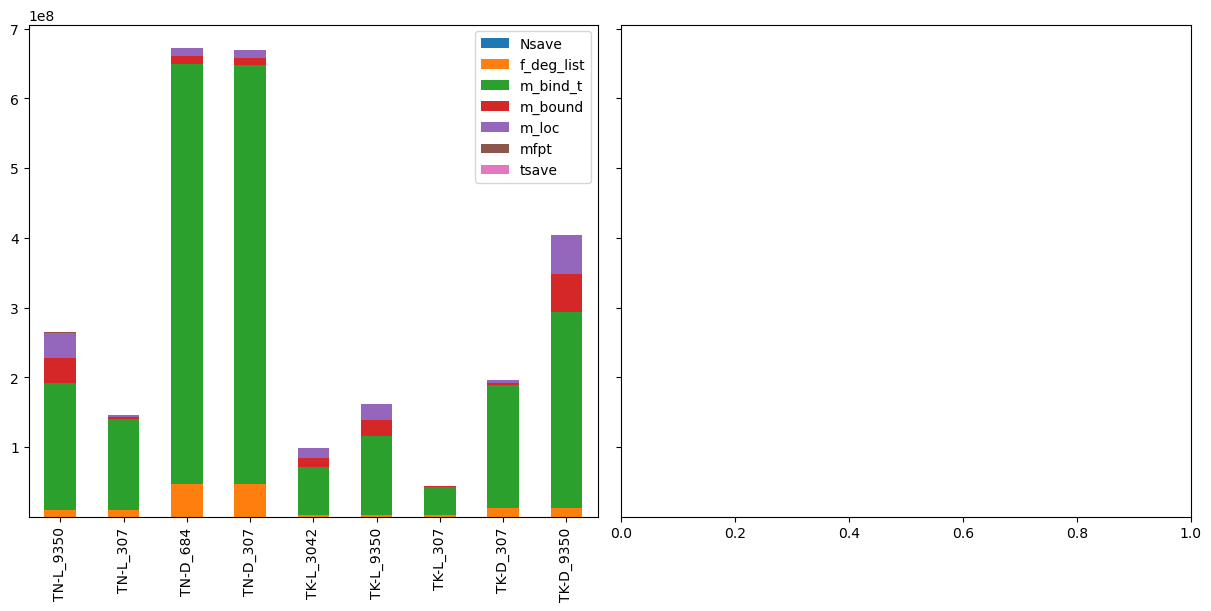

In [11]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    # sharex=True,
    sharey=True,
    figsize=(12, 6),
    constrained_layout=True,
    # width_ratios=[2, 1, 1, 1, 1],
)
df.plot.bar(ax=axs[0], stacked=True)